In [ ]:
!pip install rdkit-pypi
!pip install openpyxl
!pip install rdkit-pypi avalon_framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for avalon_framework: filename=avalon_framework-1.8.2-py3-none-any.whl size=3868 sha256=9b86f39ebf54dbe9fb1712255e79c6c76d559c02d685a2395ce5ccf3c9edf27c
  Stored in directory: /root/.cache/pip/wheels/19/a3/86/e8991278ac56c74bdc9382f08c2790b5c3bbcd8ea5c08f9a90
Successfully built avalon_framework


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

# Morgan Training


Average F1 Score: 0.7264
Average Accuracy: 0.7596

Best F1 Score (excluding perfect): 0.9333 (Model Index: 126)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 11)


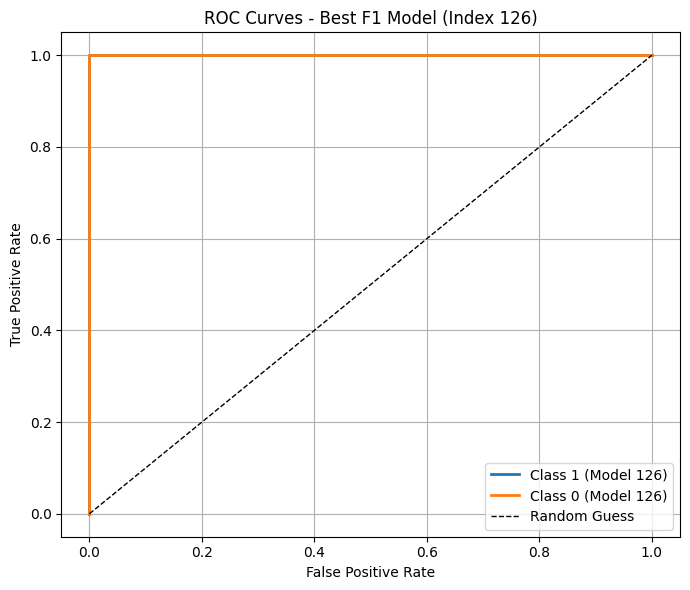

In [ ]:
# Load data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')
df.columns = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Generate features
mols = [Chem.MolFromSmiles(smiles) for smiles in df["Smiles"]]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]
fingerprints_array = np.array([list(fp.ToBitString()) for fp in fingerprints]).astype(int)
homo_values = df['HOMO (eV)'].to_numpy().astype(float)
lumo_values = df['LUMO (eV)'].to_numpy().astype(float)
features = np.column_stack((fingerprints_array, homo_values, lumo_values))
labels = df["Class"].to_numpy()

# Set seed
np.random.seed(45)

# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_Morgan_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_Morgan_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# MACCS Training


Average F1 Score: 0.7301
Average Accuracy: 0.7312

Best F1 Score (excluding perfect): 0.9474 (Model Index: 112)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 3)


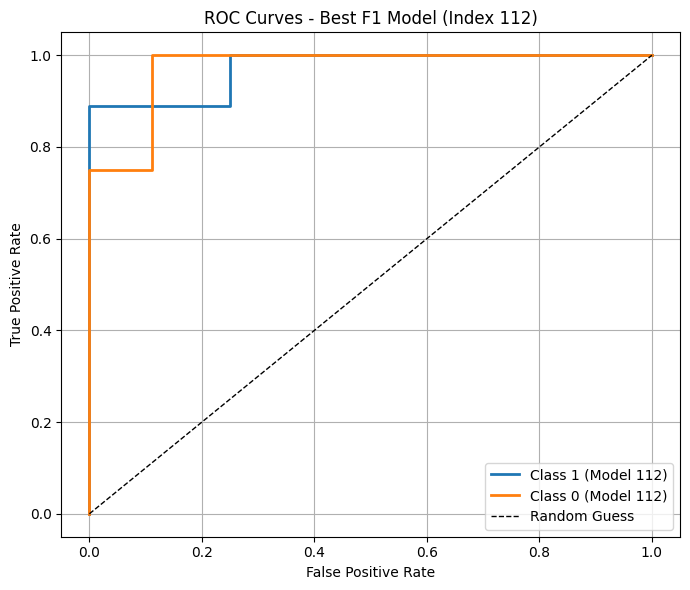

In [ ]:
from rdkit.Chem import MACCSkeys

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Generate fingerprints using RDKit's MACCS fingerprint
fingerprints = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

labels = df["Class"].to_numpy()

# Set seed
np.random.seed(45)

# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_MACCS_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_MACCS_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




# Daylight fingerprints


Average F1 Score: 0.7046
Average Accuracy: 0.7531

Best F1 Score (excluding perfect): 0.9333 (Model Index: 10)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 6)


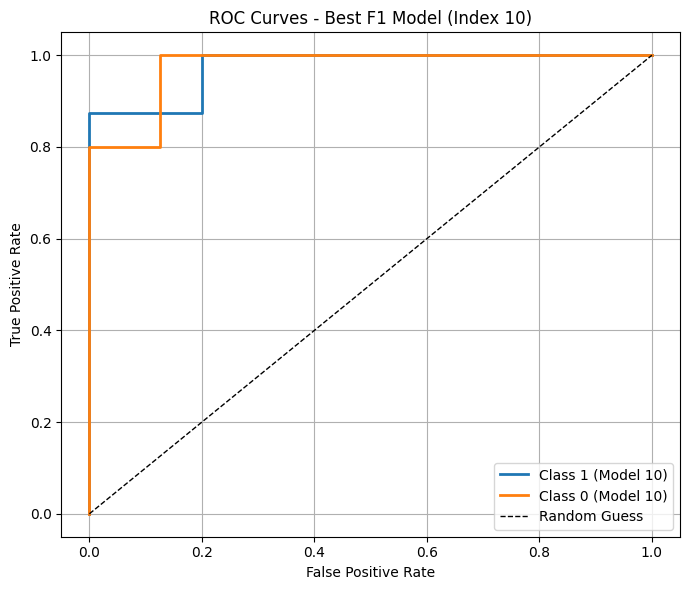

In [ ]:
from rdkit import Chem
from rdkit.Chem import DataStructs

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Create RDKit Mol objects from SMILES
Daylight_fingerprints = [Chem.RDKFingerprint(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in Daylight_fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))
labels = df["Class"].to_numpy()

# Set seed
np.random.seed(45)

# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_Daylight_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_Daylight_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()





# AtomPairs Training


Average F1 Score: 0.7965
Average Accuracy: 0.8127

Best F1 Score (excluding perfect): 0.9412 (Model Index: 139)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 3)


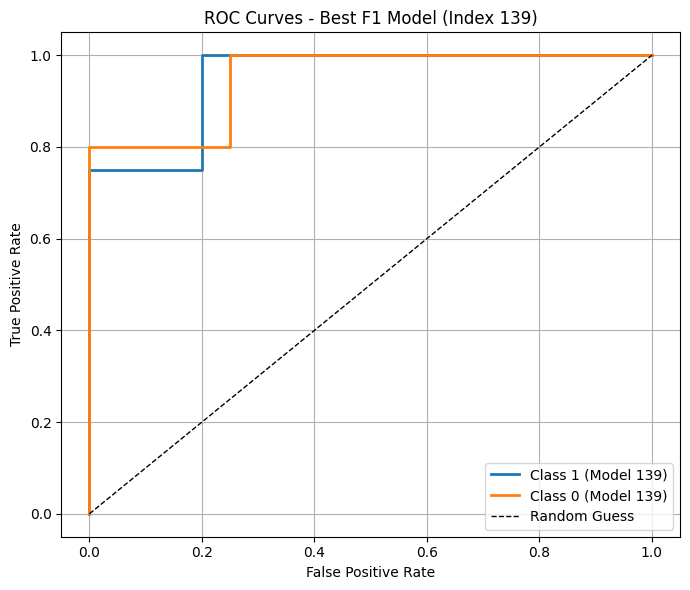


AUC (Class 1): 0.9500
AUC (Class 0): 0.9500


In [ ]:
from rdkit.Chem import rdMolDescriptors

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
atom_pairs_fingerprints = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in atom_pairs_fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

labels = df["Class"].to_numpy()


# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_AtomPairs_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_AtomPairs_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import auc

# Calculate AUC for each class
roc_class1 = roc_best_model[roc_best_model["Class"] == "Class 1"]
roc_class0 = roc_best_model[roc_best_model["Class"] == "Class 0"]

auc_class1 = auc(roc_class1["FPR"], roc_class1["TPR"])
auc_class0 = auc(roc_class0["FPR"], roc_class0["TPR"])

print(f"\nAUC (Class 1): {auc_class1:.4f}")
print(f"AUC (Class 0): {auc_class0:.4f}")



# Avalon Training


Average F1 Score: 0.7633
Average Accuracy: 0.7735

Best F1 Score (excluding perfect): 0.9412 (Model Index: 42)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 8)


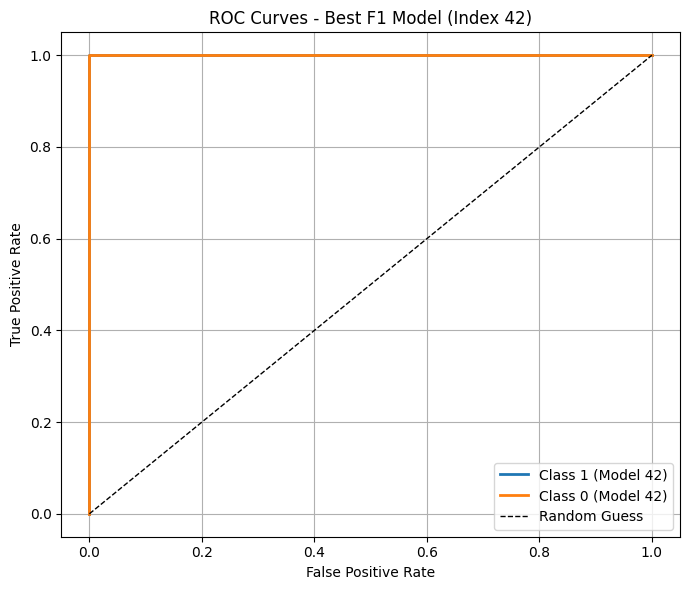

In [ ]:
from rdkit import Chem
from rdkit.Avalon import pyAvalonTools

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Avalon_fingerprints = [pyAvalonTools.GetAvalonFP(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in Avalon_fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

labels = df["Class"].to_numpy()


# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_Avalon_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_Avalon_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Torsion Training


Average F1 Score: 0.7859
Average Accuracy: 0.8138

Best F1 Score (excluding perfect): 0.9474 (Model Index: 112)
Best Accuracy (excluding perfect): 0.9231 (Model Index: 3)


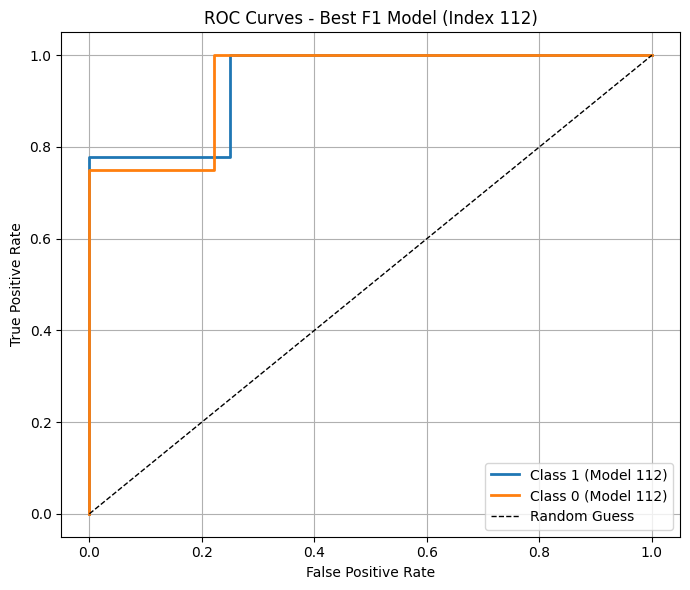

In [ ]:
from rdkit.Chem import rdMolDescriptors

# Load the Excel file containing SMILES, CLASS, HOMO, and LUMO data
df = pd.read_excel('HOMO-LUMO-energies.xlsx')  # Replace 'your_excel_file.xlsx' with the actual file name

# Define column names for better clarity
column_names = ["Cmpd Lab", "Smiles", "dFF", "HOMO (eV)", "LUMO (eV)"]

# Rename the DataFrame columns
df.columns = column_names

# Extract columns using descriptive variable names
smiles_column = df['Smiles']
ff_column = df['dFF']
homo_column = df['HOMO (eV)']
lumo_column = df['LUMO (eV)']

# Convert SMILES column to a list
smiles_list = smiles_column.to_list()

# Convert F/F columns to numeric arrays
ff_values = ff_column.to_numpy().astype(float)

# Convert HOMO and LUMO columns to numeric arrays
homo_values = homo_column.to_numpy().astype(float)
lumo_values = lumo_column.to_numpy().astype(float)

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
torsion_fingerprints = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in mols]

# Create 'labels' array based on positive and negative numbers
df["Class"] = (df["dFF"] > 0.3).astype(int)

# Set a fixed random seed for reproducibility
seed_value = 45
np.random.seed(seed_value)

# Convert RDKit fingerprints to a list of lists
fingerprints_list = [list(fp.ToBitString()) for fp in torsion_fingerprints]

# Combine fingerprints, HOMO, and LUMO into features
features = np.column_stack((np.array(fingerprints_list), homo_values, lumo_values))

labels = df["Class"].to_numpy()


# Initialize
num_models = 200
metrics_data = []
roc_data = []

# Train models
for i in range(num_models):
    perm = np.random.permutation(len(features))
    X_shuffled = features[perm]
    y_shuffled = labels[perm]

    x_train, x_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=i)
    model = SVC(probability=True)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics_data.append({
        "Model Index": i + 1,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })

    # ROC for class 1
    fpr1, tpr1, _ = roc_curve(y_test, y_prob, pos_label=1)
    for f, t in zip(fpr1, tpr1):
        roc_data.append({"Model Index": i + 1, "Class": "Class 1", "FPR": f, "TPR": t})

    # ROC for class 0
    y_prob_0 = 1 - y_prob
    fpr0, tpr0, _ = roc_curve(y_test, y_prob_0, pos_label=0)
    for f, t in zip(fpr0, tpr0):
        roc_data.append({"Model Index": i + 1, "Class": "Class 0", "FPR": f, "TPR": t})

# Save metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("model_metrics_200_Torsion_HOMO_LUMO.csv", index=False)

# Average metrics
avg_f1 = metrics_df["F1 Score"].mean()
avg_acc = metrics_df["Accuracy"].mean()
print(f"\nAverage F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

# Best scores excluding perfect
non_perfect = metrics_df[(metrics_df["F1 Score"] < 1.0) & (metrics_df["Accuracy"] < 1.0)]
best_f1_row = non_perfect.loc[non_perfect["F1 Score"].idxmax()]
best_acc_row = non_perfect.loc[non_perfect["Accuracy"].idxmax()]

print(f"\nBest F1 Score (excluding perfect): {best_f1_row['F1 Score']:.4f} (Model Index: {int(best_f1_row['Model Index'])})")
print(f"Best Accuracy (excluding perfect): {best_acc_row['Accuracy']:.4f} (Model Index: {int(best_acc_row['Model Index'])})")

# Save and plot ROC for best F1 model
best_model_index = int(best_f1_row["Model Index"])
roc_df = pd.DataFrame(roc_data)
roc_best_model = roc_df[roc_df["Model Index"] == best_model_index]

# Save to CSV
roc_best_model.to_csv("best_model_roc_data_Torsion_HOMO_LUMO.csv", index=False)

# Plot both class ROC
plt.figure(figsize=(7, 6))
for cls in ["Class 1", "Class 0"]:
    cls_df = roc_best_model[roc_best_model["Class"] == cls]
    plt.plot(cls_df["FPR"], cls_df["TPR"], label=f"{cls} (Model {best_model_index})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - Best F1 Model (Index {best_model_index})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

